In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pickle
import gzip

In [3]:
path_to_training_file="/Users/rakadalal/Desktop/Loan Prediction/train.csv"

df = pd.read_csv(path_to_training_file)#Reading the dataset in a dataframe using Pandas

In [4]:
# looking at missing values in all the variables
df.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
# Frequency distribution of Self_Employed variable
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [6]:
# Since ~86% values of Self_Employed are “No”, I am imputing the missing values as “No”
df['Self_Employed'].fillna('No',inplace=True)

In [7]:
# Pivot table to provide median values for all the groups of unique values of Self_Employed and Education features.
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]
# Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [8]:
# Filling missing values of all variables
# Since ~86% values of Gender are “Male”, I am imputing the missing values as “Male”
df['Gender'].fillna('Male', inplace=True)
# Since ~65% values of Married are “Yes”, I am imputing the missing values as “Yes”
df['Married'].fillna('Yes', inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

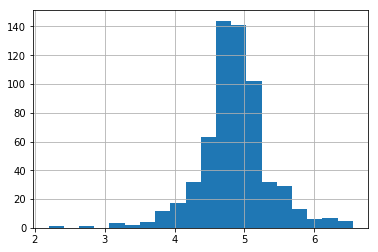

In [9]:
# Treating extreme values of LoanAmount by log transformation
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)
plt.show()

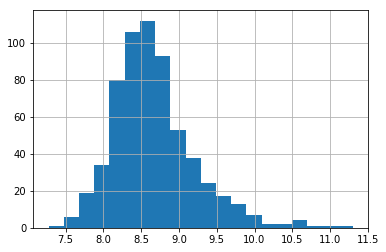

In [10]:
# Combining ApplicantIncome and CoapplicantIncome
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
# Treating extreme values of TotalIncome by log transformation
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['TotalIncome_log'].hist(bins=20) 
plt.show()

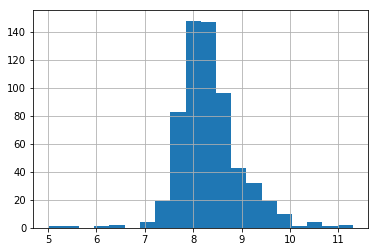

In [11]:
# Treating extreme values of ApplicantIncome by log transformation
df['ApplicantIncome_log'] = np.log(df['ApplicantIncome'])
df['ApplicantIncome_log'].hist(bins=20) 
plt.show()

In [12]:
# Converting all categorical variables into numeric by encoding the categories
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes 

Loan_ID                 object
Gender                   int64
Married                  int64
Dependents               int64
Education                int64
Self_Employed            int64
ApplicantIncome          int64
CoapplicantIncome      float64
LoanAmount             float64
Loan_Amount_Term       float64
Credit_History         float64
Property_Area            int64
Loan_Status              int64
LoanAmount_log         float64
TotalIncome            float64
TotalIncome_log        float64
ApplicantIncome_log    float64
dtype: object

In [105]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
    #Fit the model:
    model.fit(data[predictors],data[outcome])

    #Make predictions on training set:
    predictions = model.predict(data[predictors])

    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

    #Perform k-fold cross-validation with 5 folds
    kf = KFold(n_splits=6, random_state=None, shuffle=True)
    error = []
    for train, test in kf.split(data[predictors]):
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])

        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]

        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)

        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))

    print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    #Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome]) 

In [15]:
outcome_var = 'Loan_Status'

In [43]:
# Logistic Regression Model
model = LogisticRegression(penalty='l2')
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.952%


In [72]:
# Logistic Regression Model with a different combination of variables
model = LogisticRegression(penalty='l2', tol=0.01)
predictor_var = ['TotalIncome_log','Credit_History', 'Education', 'Property_Area', 'Dependents', 'Married', 'Self_Employed']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.942%


In [37]:
# Logistic Regression Model with a different combination of variables
model = LogisticRegression()
predictor_var = ['TotalIncome_log', 'LoanAmount_log', 'Credit_History', 'Education', 'Property_Area', 'Dependents']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.948%


In [54]:
# Decision Tree Model
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 88.925%
Cross-Validation Score : 68.077%


In [58]:
# Decision Tree Model with a different combination of variables
model = DecisionTreeClassifier()
predictor_var = ['Loan_Amount_Term', 'LoanAmount_log', 'Credit_History', 'Education', 'Property_Area', 'Dependents']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 96.580%
Cross-Validation Score : 66.124%


In [59]:
# Random Forest Classifier
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 79.644%


In [60]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print (featimp)

Credit_History      0.268845
TotalIncome_log     0.259473
LoanAmount_log      0.228873
Dependents          0.054237
Property_Area       0.049653
Loan_Amount_Term    0.043632
Married             0.025024
Education           0.024471
Self_Employed       0.023778
Gender              0.022015
dtype: float64


In [102]:
# Features with most importance
predictor_var = ['Credit_History','TotalIncome_log', 'LoanAmount_log', 'Dependents', 'Property_Area', 'Loan_Amount_Term']

In [108]:
# Tuning of parameters
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [6, 7, 8, 9],
    'max_features': [1, 2, 3],
    'min_samples_split': [21, 25, 28],
    'n_estimators': [30, 40, 50]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(df[predictor_var], df[outcome_var])
grid_search.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_features=1, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=6 
[CV] max_features=1, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=6 
[CV] max_features=1, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=6 
[CV] max_features=1, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=6 
[CV]  max_features=1, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=6, total=   0.3s
[CV] max_features=1, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=6 
[CV]  max_features=1, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=6, total=   0.3s
[CV] max_features=1, min_samples_split=21, bootstrap=True, n_estimators=40, max_depth=6 
[CV]  max_features=1, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=6, total=   0.3s
[CV] max_features=1, min_samples_split=21, bootstrap=True, n_estimators=40, max_depth=6 
[C

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s


[CV]  max_features=1, min_samples_split=28, bootstrap=True, n_estimators=30, max_depth=6, total=   0.5s
[CV] max_features=1, min_samples_split=28, bootstrap=True, n_estimators=40, max_depth=6 
[CV]  max_features=1, min_samples_split=28, bootstrap=True, n_estimators=30, max_depth=6, total=   0.5s
[CV] max_features=1, min_samples_split=28, bootstrap=True, n_estimators=40, max_depth=6 
[CV]  max_features=1, min_samples_split=28, bootstrap=True, n_estimators=40, max_depth=6, total=   0.6s
[CV] max_features=1, min_samples_split=28, bootstrap=True, n_estimators=40, max_depth=6 
[CV]  max_features=1, min_samples_split=28, bootstrap=True, n_estimators=40, max_depth=6, total=   0.6s
[CV] max_features=1, min_samples_split=28, bootstrap=True, n_estimators=50, max_depth=6 
[CV]  max_features=1, min_samples_split=28, bootstrap=True, n_estimators=40, max_depth=6, total=   0.4s
[CV] max_features=1, min_samples_split=28, bootstrap=True, n_estimators=50, max_depth=6 
[CV]  max_features=1, min_samples_s

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.8s


[CV]  max_features=1, min_samples_split=25, bootstrap=True, n_estimators=40, max_depth=7, total=   0.4s
[CV] max_features=1, min_samples_split=25, bootstrap=True, n_estimators=40, max_depth=7 
[CV]  max_features=1, min_samples_split=25, bootstrap=True, n_estimators=40, max_depth=7, total=   0.4s
[CV]  max_features=1, min_samples_split=25, bootstrap=True, n_estimators=40, max_depth=7, total=   0.4s
[CV] max_features=1, min_samples_split=25, bootstrap=True, n_estimators=50, max_depth=7 
[CV] max_features=1, min_samples_split=25, bootstrap=True, n_estimators=50, max_depth=7 
[CV]  max_features=1, min_samples_split=25, bootstrap=True, n_estimators=40, max_depth=7, total=   0.4s
[CV] max_features=1, min_samples_split=25, bootstrap=True, n_estimators=50, max_depth=7 
[CV]  max_features=1, min_samples_split=25, bootstrap=True, n_estimators=40, max_depth=7, total=   0.3s
[CV] max_features=1, min_samples_split=25, bootstrap=True, n_estimators=50, max_depth=7 
[CV]  max_features=1, min_samples_s

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   47.3s


[CV]  max_features=2, min_samples_split=28, bootstrap=True, n_estimators=50, max_depth=8, total=   0.7s
[CV] max_features=3, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=8 
[CV]  max_features=3, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=8, total=   0.4s
[CV] max_features=3, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=8 
[CV]  max_features=3, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=8, total=   0.4s
[CV] max_features=3, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=8 
[CV]  max_features=2, min_samples_split=28, bootstrap=True, n_estimators=50, max_depth=8, total=   0.7s
[CV] max_features=3, min_samples_split=21, bootstrap=True, n_estimators=40, max_depth=8 
[CV]  max_features=3, min_samples_split=21, bootstrap=True, n_estimators=30, max_depth=8, total=   0.4s
[CV] max_features=3, min_samples_split=21, bootstrap=True, n_estimators=40, max_depth=8 
[CV]  max_features=3, min_samples_s

[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.3min finished


{'bootstrap': True,
 'max_depth': 9,
 'max_features': 1,
 'min_samples_split': 25,
 'n_estimators': 50}

In [114]:
# Random Forest Classifier after tuning with 6 most important features
model = RandomForestClassifier(n_estimators=50, max_depth=9, max_features=1, min_samples_split=25, bootstrap=True)

classification_model(model, df,predictor_var,outcome_var)

Accuracy : 83.225%
Cross-Validation Score : 80.621%


In [110]:
# Saving the best model to disk
path_to_model='./'
f = gzip.open(path_to_model+'model.pklz','wb')
pickle.dump(model,f)
f.close()